In [7]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

def decomposition(data_to_transform, decomposition_model, n_components):
    model = decomposition_model(n_components=n_components)
    data_to_transform = pd.DataFrame(model.fit_transform(data_to_transform))
    return data_to_transform

def normalization(data_to_normalize, normalization_model):
    model = normalization_model()
    data_to_normalize = pd.DataFrame(model.fit_transform(data_to_normalize))
    return data_to_normalize

def get_two_humped_camel(pred, pred_prob, test_target, count_step):
    answer = (pred == test_target)
    step = 1 / count_step
    steps = np.cumsum([step for i in range(count_step)])
    good = []
    bad = []

    for i in steps:
        ppp = np.array(test_target)[(pred_prob < i) & (pred_prob > i - step)]
        good.append(sum(ppp == True))
        bad.append(sum(ppp == False))
        
    return good, bad, steps

def get_metrics(y_test, y_pred, y_prob):
    if len(y_pred) != 0:
        r3 = lambda x: round(x, 3)
        ac = r3(metrics.accuracy_score(y_test, y_pred))
        f1 = r3(metrics.f1_score(y_test, y_pred, pos_label=0)), r3(metrics.f1_score(y_test, y_pred))
        recall = r3(metrics.recall_score(y_test, y_pred, pos_label=0)), r3(metrics.recall_score(y_test, y_pred))
        precision = (r3(metrics.precision_score(y_test, y_pred, pos_label=0)),
                    r3(metrics.precision_score(y_test, y_pred)))
        roc_auc = r3(metrics.roc_auc_score(y_test, y_prob[:,1]))
        fpr, tpr = metrics.roc_curve(y_test, y_prob[:,1])[:2]
        return ac, f1, recall, precision, roc_auc, fpr, tpr
    else:
        return [None, None, None, None, None, None, None]
def fill(string):
    return string + (40 - len(string)) * ' ' + '|'
    
def go_to_proc(y_test, y_pred, y_prob, proc):
    indices_to_hold = []
    for i in range(len(y_prob)):
        if y_prob[i][0] >= proc or y_prob[i][0] <= 1 - proc:
            indices_to_hold.append(i)
    return y_test[indices_to_hold], y_pred[indices_to_hold], y_prob[indices_to_hold]

def get_name(model):
    if 'catboost' in str(model):
        return "CatBoostClassifier"
    elif "__main__" in str(model):
        return "CustomModel"
    else:
        return str(model)[:str(model).find('(')]

def get_model_info(model, data, target, train, test=None, proc=0.5, output=True, graphics = True, return_=True):
    if test == None:
        test = data.shape[0]
    name = get_name(model)
    X_train, y_train = np.array(data[:train]), np.array(target[:train])
    X_test , y_test  = np.array(data[train:train+test]), np.array(target[train:train+test])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    ac, f1, recall, precision, roc_auc, fpr, tpr = get_metrics(y_test, y_pred, y_prob)
    
    if proc == 0.5:
        y_test_p, y_pred_p, y_prob_p = y_test, y_pred, y_prob
        ac_p, f1_p, recall_p, precision_p, roc_auc_p, fpr_p, tpr_p = ac, f1, recall, precision, roc_auc, fpr, tpr
    else:
        y_test_p, y_pred_p, y_prob_p = go_to_proc(y_test, y_pred, y_prob, proc)
        ac_p, f1_p, recall_p, precision_p, roc_auc_p, fpr_p, tpr_p = get_metrics(y_test_p, y_pred_p, y_prob_p)
    
    if output == True:    
        print(' '*6 + "-"*39 + 12*' ' +  '-'*39,
              ' '*5 +fill(f"| {name}") + 10*' ' + fill(f"| {name}, proc={proc}"),
              ' '*6 +("-"*39) + 12*' ' + ("-"*39),
              ' '*5 +fill(f"| accuracy     = {ac}") + 10*' ' + fill(f"| accuracy     = {ac_p}") ,
              ' '*5 +fill(f"| precision    ={precision}") + 10*' ' + fill(f"| precision    ={precision_p}"),
              ' '*5 +fill(f"| recall       ={recall}") + 10*' ' + fill(f"| recall       ={recall_p}"), 
              ' '*5 +fill(f"| f1_score     ={f1}") + 10*' ' + fill(f"| f1_score     ={f1_p}"), 
              ' '*5 +fill(f"| roc_auc      = {roc_auc}") + 10*' ' + fill(f"| roc_auc      = {roc_auc_p}"),
              ' '*5 +fill(f"| true_pred    = {int(len(y_test)*ac)}")+ 10*' ' + fill(f"| true_pred    = {int(len(y_test_p)*ac_p)}"),
              ' '*5 +fill(f"| len_pred     = {len(y_test)}") + 10*' ' + fill(f"| len_pred     = {len(y_test_p)}"),
              ' '*6 + "-"*39 + 12*' ' + "-"*39,
              sep = "\n")
    
    if graphics == True:
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows = 1, figsize = (14, 5))
        ax1.set_title('Receiver Operating Characteristic')
        ax1.plot([0.0,1.0], [0.0,1.0], linestyle='dashed', c='r', label='full random ROC')
        ax1.plot(fpr, tpr, c='b', label = name)
        ax1.grid()
        ax1.set_ylabel('True Positive Rate')
        ax1.set_xlabel('False Positive Rate')
        if proc > 0.5:
            ax1.plot(fpr_p, tpr_p, c='g', label = name+f' proc {proc}')
            ax1.legend(loc = 'lower right')
        good, bad, steps = get_two_humped_camel(y_pred, y_prob[:,1], list(y_test), count_step=10)
        ax2.plot(steps, good, label='Good', c = 'g')
        ax2.plot(steps, bad, label='Bad', c = 'r')
        ax2.grid()
        ax2.legend()
    
    if return_ == True:
        if proc > 0.5:
            return [model, train, len(y_test), int(len(y_test)*ac), ac, f1, recall, precision,
                    roc_auc, len(y_test_p), int(len(y_test_p)*ac), ac_p, f1_p, recall_p, precision_p, roc_auc_p]
        else:
            return [model, train, len(y_test), ac, f1, recall, precision, roc_auc]

# Example

      ---------------------------------------            ---------------------------------------
     | KNeighborsClassifier                  |          | KNeighborsClassifier, proc=0.6        |
      ---------------------------------------            ---------------------------------------
     | accuracy     = 0.562                  |          | accuracy     = 0.652                  |
     | precision    =(0.545, 0.592)          |          | precision    =(0.671, 0.62)           |
     | recall       =(0.701, 0.426)          |          | recall       =(0.759, 0.514)          |
     | f1_score     =(0.613, 0.495)          |          | f1_score     =(0.712, 0.562)          |
     | roc_auc      = 0.615                  |          | roc_auc      = 0.676                  |
     | true_pred    = 562                    |          | true_pred    = 166                    |
     | len_pred     = 1000                   |          | len_pred     = 256                    |
      ----------------

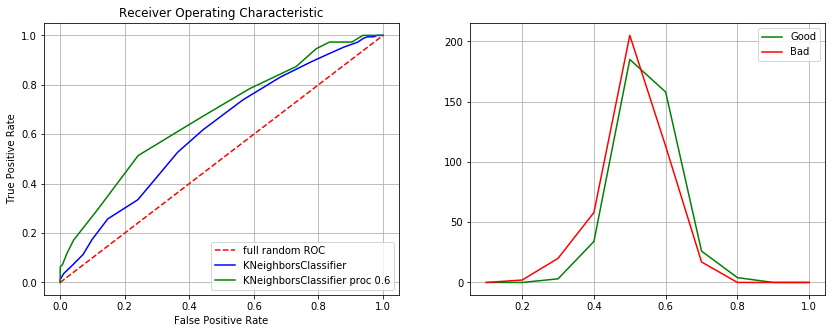

In [13]:
from sklearn.neighbors import KNeighborsClassifier
data = pd.read_csv('data5433v2.csv')
target = data.target
data = data.drop('target', axis=1)

get_model_info(model=KNeighborsClassifier(n_neighbors=50), 
               data=data, target=target, train=4433, proc=0.6, return_=None)